In [1]:
import sys
import numpy as np
import pandas as pd
sys.path.append('../..')

In [2]:
from tqdm import tqdm
import itertools
from matplotlib import pyplot as plt

In [3]:
from lamarck.assistant import GenomeCreator
from lamarck.assistant import PopulationCreator
from lamarck import Environment
from lamarck import Population

# Setup

#### Process

In [4]:
maxrange = 12

In [5]:
def process(x, y):
    val = np.sin(x)*x + np.sin(y)*y
    return {'val': val}

Text(0, 0.5, 'val')

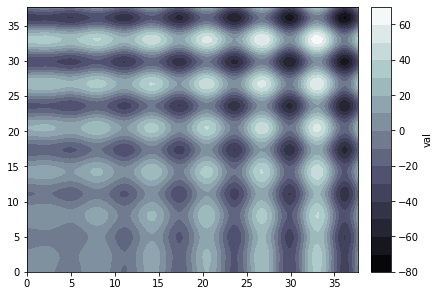

In [6]:
x = np.linspace(0, maxrange*np.pi, 100)
y = np.linspace(0, maxrange*np.pi, 100)
Xi, Yi = np.meshgrid(x, y)
Z = process(Xi, Yi)['val']

fig, ax = plt.subplots(constrained_layout=True)
CS = ax.contourf(x, y, Z, 15, cmap=plt.cm.bone)
cbar = fig.colorbar(CS)
cbar.ax.set_ylabel('val')

# Finding best - GA

#### Genome Creation

In [7]:
genome_creator = GenomeCreator()

In [8]:
genome_creator.add_gene_specs.numeric(name='x',
                                      min=0,
                                      max=maxrange*np.pi,
                                      progression='linear',
                                      domain='float')

genome_creator.add_gene_specs.numeric(name='y',
                                      min=0,
                                      max=maxrange*np.pi,
                                      progression='linear',
                                      domain='float')

genome_blueprint = genome_creator.get_genome_blueprint()

In [9]:
genome_blueprint

{'x': {'type': 'numeric',
  'domain': 'float',
  'ranges': {'min': 0, 'max': 37.69911184307752, 'progression': 'linear'}},
 'y': {'type': 'numeric',
  'domain': 'float',
  'ranges': {'min': 0, 'max': 37.69911184307752, 'progression': 'linear'}}}

#### Population

In [10]:
ndet=20
nrand=600

<AxesSubplot:xlabel='x', ylabel='y'>

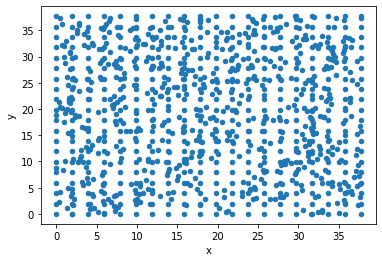

In [11]:
pop_creator = PopulationCreator(genome_blueprint)
pop = pop_creator.create.det(ndet) + pop_creator.create.rand(nrand)
pop.define()
pop.plot.variable_pair('x', 'y')

### Simulate

In [12]:
output = 'val'
objective = 'max'
n_generations = 50

In [13]:
# Environment
env = Environment()
env.config.set_multi(True)
env.config.set_process(process)

In [14]:
pbar = tqdm(range(n_generations))
for _ in pbar:
    pbar.set_description('Simulating...')
    env.simulate(pop)
    pbar.set_description('Applying Fitness...')
    pop.apply_fitness.single_objective(output, objective=objective)
    pbar.set_description('Selecting...')
    pop.select()
    pbar.set_description('Repopulating...')
    #pop.reproduce.mutate(p=0.01)
    pop.reproduce.tournament(n_dispute=3)

Repopulating...: 100%|██████████| 50/50 [00:05<00:00,  9.62it/s]    


In [15]:
gen = 0

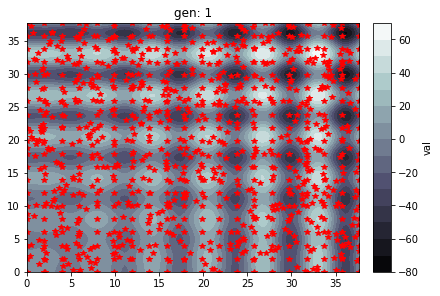

In [16]:
df = pop.datasets.get_generation_from_history(gen)
gen += 1

ax.lines = []
ax.plot(df.x, df.y, 'r*')
ax.set_title(label=f'gen: {gen}')
ax.figure

<AxesSubplot:xlabel='generation', ylabel='val'>

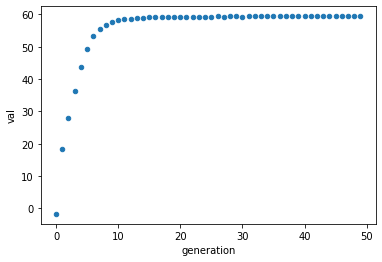

In [17]:
pop.plot.history('val', 'mean')

# Starting away from optimum

In [18]:
threshold = 20

In [19]:
popdf = pop.datasets.get_generation_from_history(0)
f = (popdf.x < threshold) & (popdf.y < threshold)
popdf = popdf[f].reset_index(drop=True)
popdf

,x,y,val,criteria,generation
0,19.841638,19.841638,33.221508,33.221508,0
1,19.841638,13.889146,30.074896,30.074896,0
2,13.889146,19.841638,30.074896,30.074896,0
3,19.649689,14.407984,27.980489,27.980489,0
4,13.889146,13.889146,26.928285,26.928285,0
...,...,...,...,...,...
269,16.641934,10.859205,-24.138292,-24.138292,0
270,18.435020,17.415836,-24.677456,-24.677456,0
271,17.896534,11.387706,-25.112047,-25.112047,0
272,17.672753,11.121450,-27.352188,-27.352188,0


In [20]:
new_pop = Population(genome_blueprint)
new_pop.populate.from_genome_dataframe(popdf)
new_pop.define(1000)

In [21]:
pbar = tqdm(range(n_generations))
for _ in pbar:
    pbar.set_description('Simulating...')
    env.simulate(new_pop)
    pbar.set_description('Applying Fitness...')
    new_pop.apply_fitness.single_objective(output, objective=objective)
    pbar.set_description('Selecting...')
    new_pop.select()
    pbar.set_description('Repopulating...')
    #pop.reproduce.mutate(p=0.01)
    new_pop.reproduce.tournament(n_dispute=3)

Repopulating...: 100%|██████████| 50/50 [00:05<00:00,  9.85it/s]    


## WITHOUT Mutation

In [86]:
gen = 0

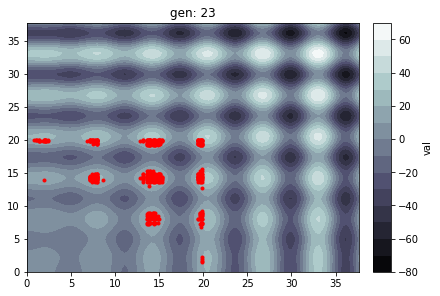

In [109]:
df = new_pop.datasets.get_generation_from_history(gen)
gen += 1

ax.lines = []
ax.plot(df.x, df.y, 'r.')
ax.set_title(label=f'gen: {gen}')
ax.figure

### Creatures get stuck

## WITH Mutation

In [24]:
new_pop2 = Population(genome_blueprint)
new_pop2.populate.from_genome_dataframe(popdf)
new_pop2.define(1000)

In [25]:
pbar = tqdm(range(n_generations))
for _ in pbar:
    pbar.set_description('Simulating...')
    env.simulate(new_pop2)
    pbar.set_description('Applying Fitness...')
    new_pop2.apply_fitness.single_objective(output, objective=objective)
    pbar.set_description('Selecting...')
    new_pop2.select()
    pbar.set_description('Repopulating...')
    new_pop2.reproduce.mutate(p=0.03)
    new_pop2.reproduce.tournament(n_dispute=3)

Repopulating...: 100%|██████████| 50/50 [00:05<00:00,  8.64it/s]    


In [110]:
gen = 0

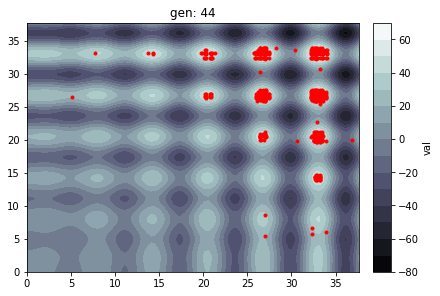

In [154]:
df = new_pop2.datasets.get_generation_from_history(gen)
gen += 1

ax.lines = []
ax.plot(df.x, df.y, 'r.')
ax.set_title(label=f'gen: {gen}')
ax.figure

<AxesSubplot:xlabel='generation', ylabel='val'>

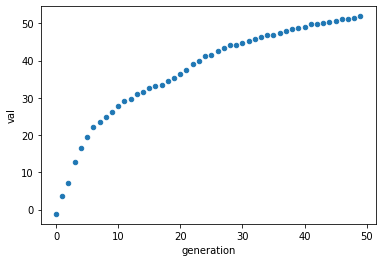

In [28]:
new_pop2.plot.history('val', 'mean')

<AxesSubplot:xlabel='generation', ylabel='val'>

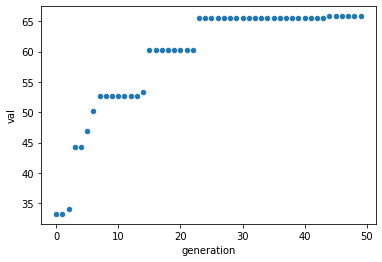

In [29]:
new_pop2.plot.history('val', 'max')

In [32]:
n = 5
domain = tuple(range(12))
length = len(domain)
perm_gen = itertools.permutations(domain, length)
end = np.math.perm(len(domain), length)
step = end // n
dist_gen = itertools.islice(perm_gen, 0, end, step)

In [33]:
next(dist_gen)

(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)

In [34]:
step

95800320